<a href="https://colab.research.google.com/github/saktiworkstation/road-to-ai-developer/blob/main/Studi_Kasus_Join_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install pyspark

# Sakti Kusuma Aji | 22.11.4677

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_date, year, when

# Buat Spark session
spark = SparkSession.builder.master("local").appName("Dataset pesawat Studi Kasus").getOrCreate()

In [93]:
flights = spark.read.csv("/content/flights_small.csv", header=True, inferSchema=True)
planes = spark.read.csv("/content/planes.csv", header=True, inferSchema=True)

In [94]:
# Rename kolom "year" pada dataset planes untuk menghindari ambiguitas
planes = planes.withColumnRenamed("year", "plane_year")

**Pre processing**

In [95]:
# Preprocessing data untuk mengisi data yang kosong
# Mengisi nilai null pada kolom "dep_delay" dan "arr_delay" di dataset flights dengan 0
flights = flights.fillna({"dep_delay": 0, "arr_delay": 0})

In [96]:
# Mengisi nilai null pada kolom "plane_year" di dataset planes dengan nilai rata-rata tahun pembuatan pesawat
avg_plane_year = planes.selectExpr("avg(plane_year) as avg_year").collect()[0]["avg_year"]
planes = planes.withColumn("plane_year", when(col("plane_year").isNull(), avg_plane_year).otherwise(col("plane_year").cast("int")))

In [97]:
# Mengisi nilai null pada kolom "manufacturer" dan "model" di dataset planes dengan "Unknown"
planes = planes.fillna({"manufacturer": "Unknown", "model": "Unknown"})

In [98]:
print("Flights Dataset:")
flights.show(5, truncate=False)

print("Planes Dataset:")
planes.show(5, truncate=False)

Flights Dataset:
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|12   |8  |658     |-7       |935     |-5       |VX     |N846VA |1780  |SEA   |LAX |132     |954     |6   |58    |
|2014|1    |22 |1040    |5        |1505    |5        |AS     |N559AS |851   |SEA   |HNL |360     |2677    |10  |40    |
|2014|3    |9  |1443    |-2       |1652    |2        |VX     |N847VA |755   |SEA   |SFO |111     |679     |14  |43    |
|2014|4    |9  |1705    |45       |1839    |34       |WN     |N360SW |344   |PDX   |SJC |83      |569     |17  |5     |
|2014|3    |9  |754     |-1       |1015    |1        |AS     |N612AS |522   |SEA   |BUR |127     |937     |7   |54    |
+----+-----+---+-------

In [99]:
# Join kedua dataset berdasarkan "tailnum" untuk mendapatkan informasi lengkap
flights_planes = flights.join(planes, on="tailnum", how="inner")

In [100]:
# Menampilkan 5 data pertama setelah join
flights_planes.show(5, truncate=False)

+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+-----------------------+------------+--------+-------+-----+-----+---------+
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|plane_year|type                   |manufacturer|model   |engines|seats|speed|engine   |
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+-----------------------+------------+--------+-------+-----+-----+---------+
|N846VA |2014|12   |8  |658     |-7       |935     |-5       |VX     |1780  |SEA   |LAX |132     |954     |6   |58    |2011.0    |Fixed wing multi engine|AIRBUS      |A320-214|2      |182  |NA   |Turbo-fan|
|N559AS |2014|1    |22 |1040    |5        |1505    |5        |AS     |851   |SEA   |HNL |360     |2677    |10  |40    |2006.0    |Fixed wing multi engine|BOEING      |737-8

In [101]:
# Mengetahui pesawat apa saja berdasarkan penerbangan
# Output ini akan menampilkan penerbangan mana yang menggunakan pesawat apa saja
flights_planes.select("flight", "tailnum", "manufacturer", "model").distinct().show(10, truncate=False)

+------+-------+------------+---------+
|flight|tailnum|manufacturer|model    |
+------+-------+------------+---------+
|798   |N196UW |AIRBUS      |A321-211 |
|1159  |N24211 |BOEING      |737-824  |
|4738  |N281WN |BOEING      |737-7H4  |
|5437  |N295SW |EMBRAER     |EMB-120ER|
|5417  |N297SW |EMBRAER     |EMB-120ER|
|1241  |N37413 |BOEING      |737-924ER|
|1695  |N37420 |BOEING      |737-924ER|
|1135  |N374DA |BOEING      |737-832  |
|1932  |N3750D |BOEING      |737-832  |
|2410  |N385DN |BOEING      |737-832  |
+------+-------+------------+---------+
only showing top 10 rows



In [102]:
# Mengetahui informasi tentang pabrikan pesawat mana yang lebih sering digunakan
# Menghitung jumlah penerbangan berdasarkan pabrikan
manufacturer_counts = flights_planes.groupBy("manufacturer").count().orderBy("count", ascending=False)
manufacturer_counts.show()

+--------------------+-----+
|        manufacturer|count|
+--------------------+-----+
|              BOEING| 6660|
|      BOMBARDIER INC|  895|
|              AIRBUS|  811|
|    AIRBUS INDUSTRIE|  743|
|             EMBRAER|  273|
|   MCDONNELL DOUGLAS|   47|
|            CANADAIR|    8|
|              CESSNA|    4|
|ROBINSON HELICOPT...|    3|
|  CIRRUS DESIGN CORP|    2|
|       BARKER JACK L|    1|
|                BELL|    1|
+--------------------+-----+



In [106]:
# Mengetahui umur pesawat dan hubungannya dengan jumlah penerbangan
# Membuat kolom "age" yang dihitung dari tahun saat ini dikurangi tahun pembuatan pesawat
fflights_planes = flights_planes.withColumn("age", when(col("plane_year").isNotNull(), year(current_date()) - col("plane_year").cast("int")).otherwise(None))

In [107]:
# Mengisi nilai null pada kolom "age" dengan rata-rata usia pesawat
avg_age = flights_planes.selectExpr("avg(age) as avg_age").collect()[0]["avg_age"]
flights_planes = flights_planes.withColumn("age", when(col("age").isNull(), avg_age).otherwise(col("age")))

In [108]:
# Mengelompokkan pesawat berdasarkan usia dan menghitung jumlah penerbangan
flights_by_age = flights_planes.groupBy("age").count().orderBy("age")
flights_by_age.show()

+---------------+-----+
|            age|count|
+---------------+-----+
|           10.0|  393|
|           11.0|  570|
|           12.0|  387|
|           13.0|  241|
|           14.0|  219|
|           15.0|  348|
|           16.0|  579|
|           17.0|  532|
|           18.0|  654|
|           19.0|  294|
|           20.0|  252|
|           21.0|  390|
|           22.0|  297|
|22.405601881548|   94|
|           23.0|  947|
|           24.0|  526|
|           25.0|  650|
|           26.0|  622|
|           27.0|  222|
|           28.0|  194|
+---------------+-----+
only showing top 20 rows



In [127]:
# Mengelompokkan pesawat berdasarkan usia dan jenis penerbangan (contoh berdasarkan asal dan tujuan)
flights_by_age_and_type = flights_planes.groupBy("age", "origin", "dest").count().orderBy("age", "origin", "dest")
flights_by_age_and_type.show(10)

+----+------+----+-----+
| age|origin|dest|count|
+----+------+----+-----+
|10.0|   PDX| ANC|    7|
|10.0|   PDX| ATL|   26|
|10.0|   PDX| BOS|    2|
|10.0|   PDX| CLT|    1|
|10.0|   PDX| DEN|    5|
|10.0|   PDX| DFW|    4|
|10.0|   PDX| DTW|    5|
|10.0|   PDX| FAI|    1|
|10.0|   PDX| HNL|    7|
|10.0|   PDX| IAH|    8|
+----+------+----+-----+
only showing top 10 rows



In [128]:
# Menampilkan 10 data terbawah
flights_by_age_and_type.orderBy("age", "origin", "dest", ascending=False).show(10)

+------+------+----+-----+
|   age|origin|dest|count|
+------+------+----+-----+
|2024.0|   SEA| PDX|    3|
|2024.0|   PDX| SEA|    2|
|2024.0|   PDX| RDM|    1|
|2024.0|   PDX| EUG|    2|
|  65.0|   PDX| DFW|    1|
|  49.0|   PDX| DFW|    1|
|  44.0|   PDX| DFW|    3|
|  40.0|   SEA| SLC|    1|
|  40.0|   SEA| LAX|    9|
|  39.0|   SEA| SMF|    2|
+------+------+----+-----+
only showing top 10 rows



In [129]:
# Menampilkan 10 data tengah
count_total = flights_by_age_and_type.count()
mid_index_start = (count_total // 2) - 5
flights_by_age_and_type.limit(count_total).rdd.zipWithIndex().filter(lambda x: mid_index_start <= x[1] < mid_index_start + 10).map(lambda x: x[0]).toDF().show()

+----+------+----+-----+
| age|origin|dest|count|
+----+------+----+-----+
|21.0|   SEA| ATL|    4|
|21.0|   SEA| AUS|    3|
|21.0|   SEA| BOS|    5|
|21.0|   SEA| BWI|    1|
|21.0|   SEA| CVG|    1|
|21.0|   SEA| DEN|   18|
|21.0|   SEA| DFW|   12|
|21.0|   SEA| DTW|    2|
|21.0|   SEA| FAI|    3|
|21.0|   SEA| GEG|   10|
+----+------+----+-----+



**Mencari hubungan antara umur pesawat dan jumlah penerbangan dengan metode lain**

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [113]:
# Visualisasi hubungan umur pesawat dengan jumlah penerbangan menggunakan regresi linear
# Mengubah hasil Spark DataFrame menjadi Pandas DataFrame
flights_by_age_pd = flights_by_age.toPandas()

In [114]:
# Menghilangkan baris dengan nilai age yang null
flights_by_age_pd = flights_by_age_pd.dropna(subset=['age'])

In [115]:
# Menyiapkan data untuk regresi linear
X = flights_by_age_pd[['age']].values.reshape(-1, 1)
y = flights_by_age_pd['count'].values

In [116]:
# Membuat model regresi linear
model = LinearRegression()
model.fit(X, y)

LinearRegression()

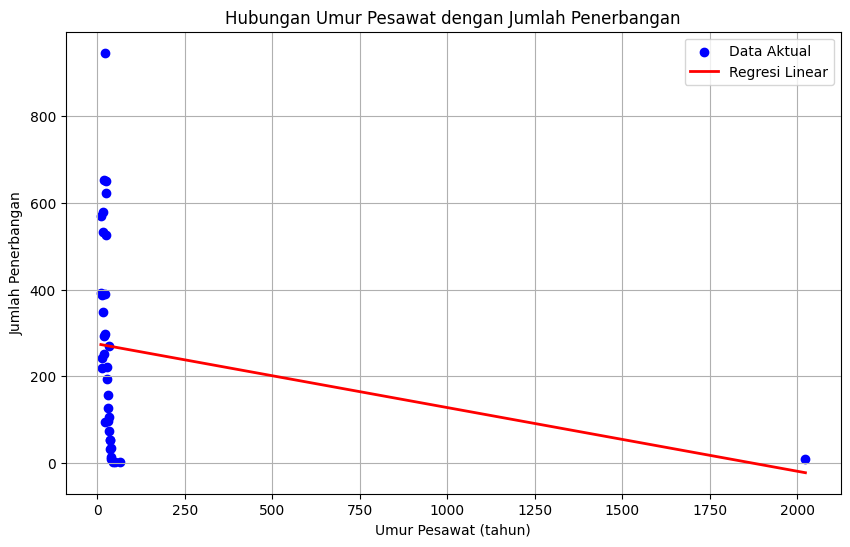

In [119]:
# Membuat prediksi
y_pred = model.predict(X)

# Plot hasil regresi linear
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Aktual')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresi Linear')
plt.xlabel('Umur Pesawat (tahun)')
plt.ylabel('Jumlah Penerbangan')
plt.title('Hubungan Umur Pesawat dengan Jumlah Penerbangan')
plt.legend()
plt.grid(True)
plt.show()

**Visualisasi hubungan umur pesawat dengan jumlah penerbangan menggunakan regresi logistik**

In [122]:
# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [123]:
# Membuat model regresi logistik
logistic_model = LogisticRegression()
logistic_model.fit(X_scaled, y)

LogisticRegression()

In [124]:
# Membuat prediksi
y_pred_logistic = logistic_model.predict(X_scaled)

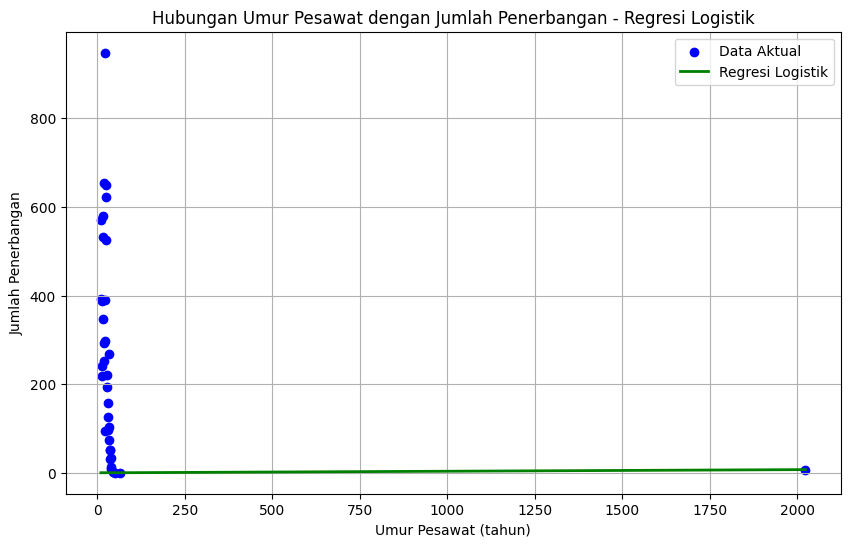

In [125]:
# Plot hasil regresi logistik
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Aktual')
plt.plot(X, y_pred_logistic, color='green', linewidth=2, label='Regresi Logistik')
plt.xlabel('Umur Pesawat (tahun)')
plt.ylabel('Jumlah Penerbangan')
plt.title('Hubungan Umur Pesawat dengan Jumlah Penerbangan - Regresi Logistik')
plt.legend()
plt.grid(True)
plt.show()